# Riiid Project
### Personalized Digital Education

<strong>Darden Capstone Project
***

# Table of Contents <a id='toc'></a>
1. [Acquire](#acquire)
2. [Prepare](#prepare)
3. [Explore](#explore)
4. [Modeling](#modeling)
5. [Conclusions](#conclusions)

## About Riiid Labs

Riiid Labs, an AI solutions provider delivering creative disruption to the education market. With a strong belief in equal opportunity in education, Riiid launched an AI tutor based on deep-learning algorithms in 2017 that attracted more than one million South Korean students. This year, the company released EdNet, the world’s largest open database for AI education containing more than 100 million student interactions. [Source](https://www.kaggle.com/c/riiid-test-answer-prediction/overview/description)

## Our Goal

This project aims to create a machine learning model that can predict whether or not a user will answer a question correctly using data provided by Riiid Labs.

# Imports

In [41]:
# General Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# Train Validate Test
from sklearn.model_selection import train_test_split

# Acquire and Prepare Files
import acquire, prepare, explore, model
from explore import rfe_ranker

# Modeling Modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Warnings 
import warnings
warnings.filterwarnings("ignore")

# 1. Acquire<a id='acquire'></a>
Acquire the data used for this project. 

[Return to Top](#toc)
***

In [2]:
# Reading in data from local files
df_train = pd.read_csv('sampled_trainset.csv')
df_validate = pd.read_csv('validate.csv')
df_test = pd.read_csv('test.csv')

df_train.shape, df_validate.shape, df_test.shape

((20964878, 18), (2590034, 18), (2693188, 18))

In [3]:
# Train Data
df_train.head(2)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,lecture_part,type_of,question_id,bundle_id,correct_answer,question_part,tags
0,0,24600,7900,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
1,25379,24600,7876,0,1,2,0,24000.0,False,NaN,NaN,NaN,NaN,7876.0,7876.0,3.0,1.0,10 94 92


In [4]:
# Validate Data
df_validate.head(2)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,lecture_part,type_of,question_id,bundle_id,correct_answer,question_part,tags
0,1326986,24600,646,0,26,3,1,29000.0,True,NaN,NaN,NaN,NaN,646.0,646.0,3.0,2.0,69 17 56 81 92
1,1353977,24600,1067,0,27,1,1,30000.0,True,NaN,NaN,NaN,NaN,1067.0,1067.0,1.0,2.0,129 2 56 162 38 92


In [5]:
# Test Data
df_test.head(2)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,lecture_part,type_of,question_id,bundle_id,correct_answer,question_part,tags
0,1453702,24600,1262,0,31,0,0,16000.0,True,NaN,NaN,NaN,NaN,1262.0,1262.0,1.0,2.0,143 71 81 29
1,1477283,24600,1348,0,32,3,1,19000.0,True,NaN,NaN,NaN,NaN,1348.0,1348.0,3.0,2.0,143 105 81 92


### Acquire Takeaways
- Data acquired from Kaggle: lectures.csv, questions.csv, and train.csv.
- Created a function to create a merged csv file of train, lectures, and questions.
- Converted the data types of numeric columns to reduce memory usage.
- Created a function to select a random sample of 100K users.
- Created a function to split the merged dataset into train, validate, and test.
    - 80% of a users data in train, 10% in validate, and 10% in test.

# 2. Prepare<a id='prepare'></a>
Prepare the data for exploration and created scaled features for modeling.<br>

[Return to Top](#toc)
***

### Run Prepare Function (found in prepare.py module)

In [6]:
# Produce train/validate/test and scaled train/validate/test dataframes
train, validate, test, train_s, validate_s, test_s = prepare.prep_riiid(df_train, df_validate, df_test)

In [7]:
# Print the shape of train
print(train.shape)

# Display first 5 rows of train
train.head()

(20554519, 22)


,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,part,tags,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy
0,0,24600,7900,0,1,False,0.275000,0,25379.0,70525.0,...,1,131 93 81,3,0.82,0.74,0.82,0.82,0.68,0.68,0.78
1,25379,24600,7876,1,0,False,0.275000,0,24758.0,70525.0,...,1,10 94 92,3,0.41,0.74,0.39,0.41,0.53,0.68,0.49
2,50137,24600,175,2,1,False,0.275000,0,20044.0,70525.0,...,1,9 10 92,3,0.36,0.74,0.34,0.36,0.44,0.68,0.52
3,0,128919,7900,0,1,False,0.333333,0,22862.0,60393.0,...,1,131 93 81,3,0.82,0.74,0.82,0.82,0.68,0.68,0.78
4,22862,128919,7876,1,0,False,0.333333,0,24620.0,60393.0,...,1,10 94 92,3,0.41,0.74,0.39,0.41,0.53,0.68,0.49


In [8]:
# Print the shape of train scaled
print(train_s.shape)

# Display first 5 rows of train scaled 
train_s.head()

(20554519, 12)


,answered_correctly,question_had_explanation,user_acc_mean,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,0,0.275000,0.82,0.74,0.82,0.82,0.68,0.68,0.78,0.0,0.000003
1,0,0,0.275000,0.41,0.74,0.39,0.41,0.53,0.68,0.49,0.0,0.000003
2,1,0,0.275000,0.36,0.74,0.34,0.36,0.44,0.68,0.52,0.0,0.000003
3,1,0,0.333333,0.82,0.74,0.82,0.82,0.68,0.68,0.78,0.0,0.000003
4,0,0,0.333333,0.41,0.74,0.39,0.41,0.53,0.68,0.49,0.0,0.000003


In [9]:
# Print the shape of validate 
print(validate.shape)

# Display first 5 rows of validate
validate.head()

(2540985, 21)


,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,avg_user_q_time,question_id,...,part,tags,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy
0,1326986,24600,646,26,1,True,0.275,0,70525.0,646,...,2,69 17 56 81 92,5,0.80,0.71,0.82,0.80,0.61,0.71,0.80
1,1353977,24600,1067,27,1,True,0.275,0,70525.0,1067,...,2,129 2 56 162 38 92,6,0.91,0.71,0.79,0.91,0.62,0.77,0.91
2,1377689,24600,940,28,0,True,0.275,0,70525.0,940,...,2,143 20 38 29,4,0.90,0.71,1.00,0.90,0.62,0.70,0.77
3,1403698,24600,10685,29,1,True,0.275,0,70525.0,10685,...,2,69 137 142 38 29,5,0.80,0.71,0.78,0.80,0.62,0.71,0.80
4,1426174,24600,817,30,1,True,0.275,0,70525.0,817,...,2,17 56 38 29,4,0.75,0.71,0.75,0.75,0.64,0.70,0.68


In [10]:
# Print the shape of validate scaled 
print(validate_s.shape)

# Display first 5 rows of validate scaled 
validate_s.head()

(2540985, 12)


,answered_correctly,question_had_explanation,user_acc_mean,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,1,1,0.275,0.80,0.71,0.82,0.80,0.61,0.71,0.80,0.0,0.000003
1,1,1,0.275,0.91,0.71,0.79,0.91,0.62,0.77,0.91,0.0,0.000003
2,0,1,0.275,0.90,0.71,1.00,0.90,0.62,0.70,0.77,0.0,0.000003
3,1,1,0.275,0.80,0.71,0.78,0.80,0.62,0.71,0.80,0.0,0.000003
4,1,1,0.275,0.75,0.71,0.75,0.75,0.64,0.70,0.68,0.0,0.000003


In [11]:
# Print the shape of test
print(test.shape)

# Display first 5 rows of test
test.head()

(2644620, 21)


,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,avg_user_q_time,question_id,...,part,tags,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy
0,1453702,24600,1262,31,0,True,0.275,0,70525.0,1262,...,2,143 71 81 29,4,0.71,0.71,0.69,0.71,0.64,0.70,0.75
1,1477283,24600,1348,32,1,True,0.275,0,70525.0,1348,...,2,143 105 81 92,4,0.82,0.71,0.86,0.82,0.65,0.70,0.81
2,1502268,24600,10686,33,0,True,0.275,0,70525.0,10686,...,2,62 137 142 38 29,5,0.56,0.71,0.56,0.56,0.64,0.71,0.56
3,1526285,24600,754,34,0,True,0.275,0,70525.0,754,...,2,137 88 38 81,4,0.68,0.71,0.88,0.68,0.65,0.70,0.66
4,1550831,24600,801,35,1,True,0.275,0,70525.0,801,...,2,143 20 38 29,4,0.88,0.71,0.88,0.88,0.65,0.70,0.77


In [12]:
# Print the shape of test scaled
print(test_s.shape)

# Display first 5 rows of test scaled
test_s.head()

(2644620, 12)


,answered_correctly,question_had_explanation,user_acc_mean,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,0,1,0.275,0.71,0.71,0.69,0.71,0.64,0.70,0.75,0.0,0.000003
1,1,1,0.275,0.82,0.71,0.86,0.82,0.65,0.70,0.81,0.0,0.000003
2,0,1,0.275,0.56,0.71,0.56,0.56,0.64,0.71,0.56,0.0,0.000003
3,0,1,0.275,0.68,0.71,0.88,0.68,0.65,0.70,0.66,0.0,0.000003
4,1,1,0.275,0.88,0.71,0.88,0.88,0.65,0.70,0.77,0.0,0.000003


### Prepare Takeaways
Used __prep_riiid__ function from __prepare.py__ to make the following changes:
- Filled missing boolean values in `question_had_explanation` with False. Missing values indicated that the question did not have an explanation or the user viewed a lecture.
- Filled missing values in `prior_question_elapsed_time` with 0. Missing values indicated that a user viewed a lecture before answering the first question in a bundle.
- Dropped columns: `lecture_id`, `tag`, `lecture_part`, `type_of`, `question_id`, `bundle_id`, `correct_answer`, `question_part`, and `tags`
- Dropped rows that represent lectures
- Filled null and inf values with 0
- Converted True and False values to 1's and 0's, respectively
- Created scaled versions of the train, validate and test sets

<b>Feature Engineering: (all in prepare.py file)</b> 
- Added column, `user_lectures_running_total` keeps a running total of the number of lectures the user has viewed
- Added column, `user_acc_mean`, that reflects the avg accuracy of a user on all questions they answered	
- Added column, `mean_container_task`
- Added column, `mean_content_accuracy`, that reflects average accuracy of all users answering a particular question
- Added column, `mean_task_accuracy`, that reflects avg accuracy of all users answering a specific group of questions
- Added column, `q_time`, that reflects the amount of milliseconds it took the user to answer the current question

<br>

# 3. Explore<a id='explore'></a>
Created graphs, ran feature selection, and performed hypothesis testing to discover drivers of answering a question correctly.<br>

[Return to Top](#toc)
***

In [13]:
# Check data types and null value counts
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 22 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   timestamp                     int64  
 1   user_id                       int64  
 2   content_id                    int64  
 3   task_container_id             int64  
 4   answered_correctly            int64  
 5   question_had_explanation      object 
 6   user_acc_mean                 float64
 7   user_lectures_running_total   int64  
 8   q_time                        float64
 9   avg_user_q_time               float64
 10  question_id                   int64  
 11  bundle_id                     int64  
 12  part                          int64  
 13  tags                          object 
 14  tag_count                     int64  
 15  mean_bundle_accuracy          float64
 16  mean_part_accuracy            float64
 17  mean_container_part_accuracy  float64
 18  mean_content_accurac

In [14]:
# Checking # of unique values of columns with int64 dtypes.
for col in train:
    if train[col].dtypes == 'int64': 
        print(f'{col} has {train[col].nunique()} unique values.')

timestamp has 15026308 unique values.
user_id has 100000 unique values.
content_id has 13515 unique values.
task_container_id has 9175 unique values.
answered_correctly has 2 unique values.
user_lectures_running_total has 362 unique values.
question_id has 13515 unique values.
bundle_id has 9762 unique values.
part has 7 unique values.
tag_count has 7 unique values.


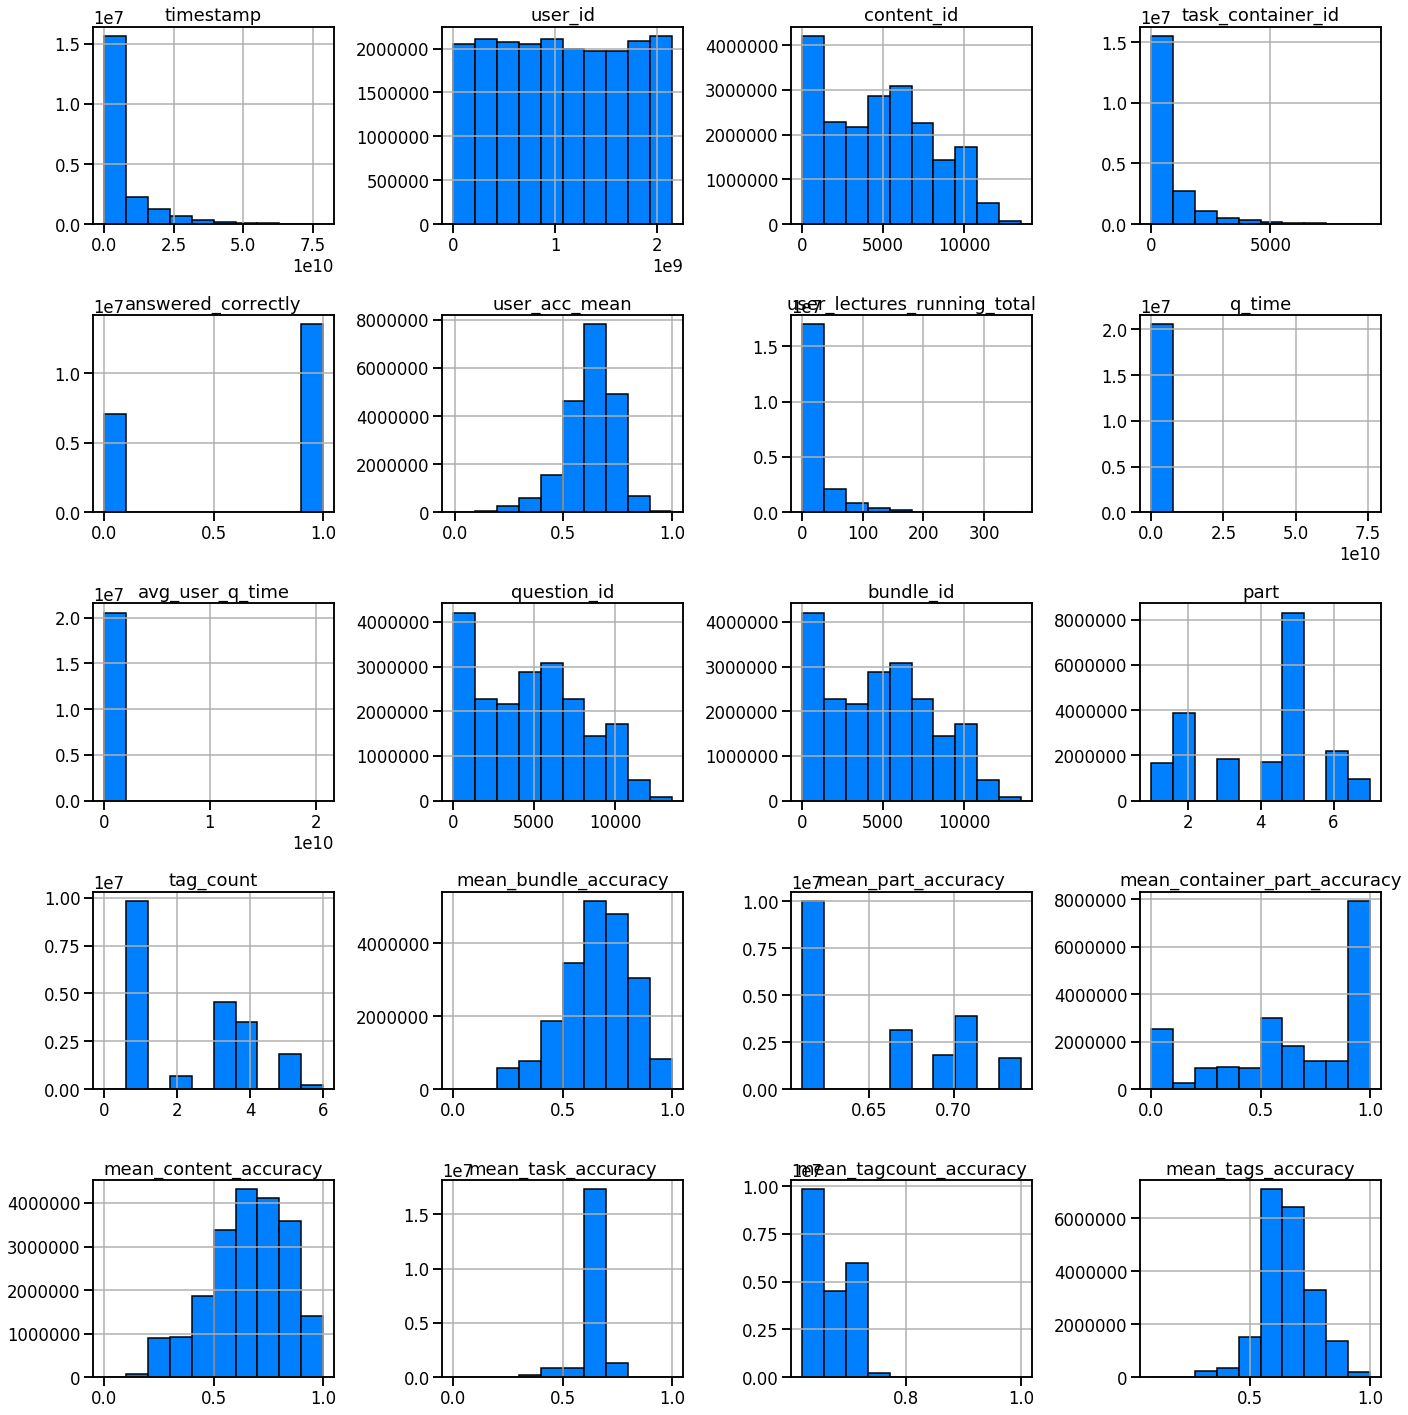

In [15]:
# Plot distributions of features
sns.set_context('talk')

train.hist(figsize=(20, 20),
           grid=True,
           color='#0080ff',
           ec='black')

plt.tight_layout()
plt.show()

- Plotting all features to understand how their values are distributed.

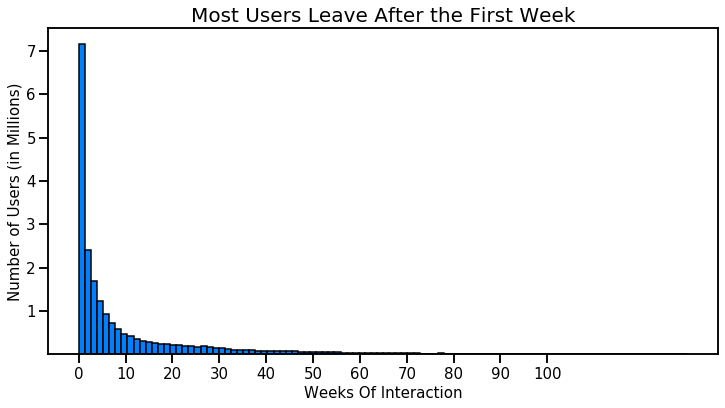

In [16]:
# User_id vs Timestamp
# Had to convert time from in milliseconds to weeks
sns.set_context('talk')
ts = df_train['timestamp']/(31536000000/52)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100, color='#0080ff', ec='black') 
plt.title("Most Users Leave After the First Week", fontsize=20)
plt.xlabel("Weeks Of Interaction", fontsize=15)
plt.ylabel("Number of Users (in Millions)", fontsize=15)
plt.xticks(np.linspace(0,100,11),rotation=0, fontsize=15)
plt.yticks(np.arange(1_000_000,8_000_000, 1_000_000), labels=['1','2','3','4','5','6', '7'], rotation=0, fontsize=15)
plt.show()

- Most users stop using the platform after the first week.
- The rest of the users stop using the platform after ten weeks.
- This shows us who our users are and platform usage behavior.

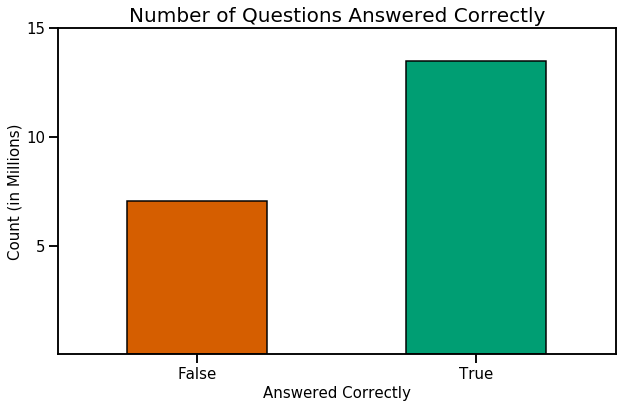

In [17]:
# Count of Questions Answered Correct
sns.set_context('talk')
plt.figure(figsize=(10,6))
train.answered_correctly.value_counts().sort_index().plot.bar(grid=True, color=['#d55e00', '#009e73'], ec='black')
answer_correctly = train.answered_correctly.mean()
plt.title("Number of Questions Answered Correctly",fontsize=20) 
plt.xlabel('Answered Correctly',fontsize=15)
plt.ylabel('Count (in Millions)',fontsize=15)
plt.xticks([0,1],labels=['False','True'],rotation=0,fontsize=15) 
plt.yticks(np.arange(5_000_000,15_000_001, 5_000_000), labels=['5', '10', '15'],rotation=0,fontsize=15) 
plt.grid(False)
plt.show()

Most questions are answered correctly.

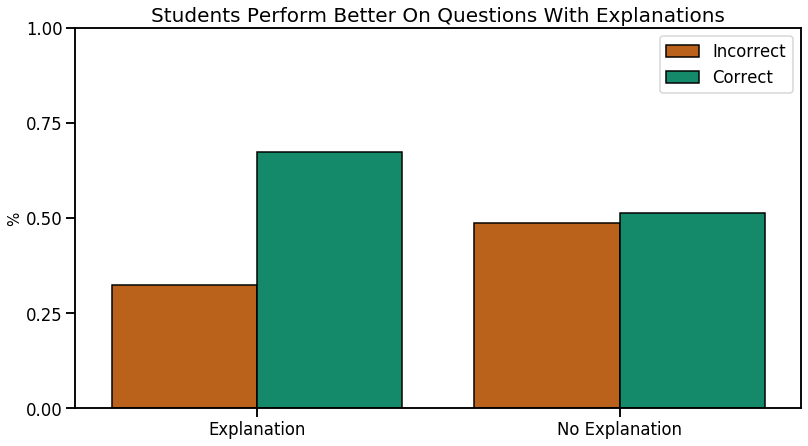

In [18]:
# Function to create plot 
# Plot displays how students perform on questions with and without explanations
explore.question_explanation_graph(train) 

- Users perform better on questions with explanations, than questions without explanations. 
    - A possible reason for this could be that the guidance from the explanations are actually helpful. 

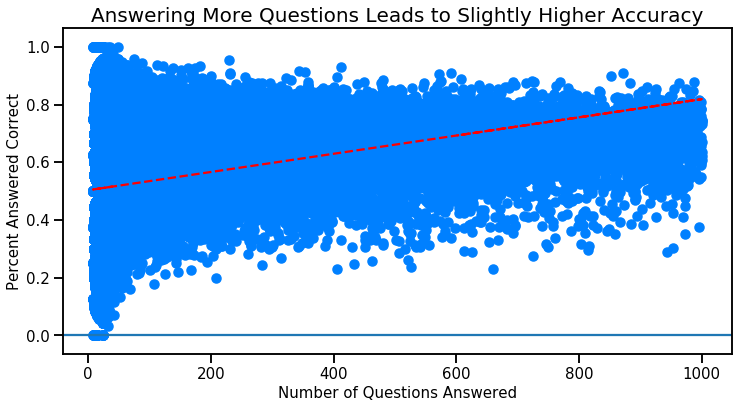

In [19]:
# Percent of Questions Answered Correct vs. Number of Questions Answered Per User
user_percent = df_train[df_train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
user_percent = user_percent.query('Answers <= 1000')

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Answering More Questions Leads to Slightly Higher Accuracy", fontsize=20)
plt.xlabel("Number of Questions Answered", fontsize=15)
plt.ylabel("Percent Answered Correct", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.axhline()

plt.show() 

- There is a slight positive linear trend for the relationship between percentage answered correct and the number of the questions answered. 

- Most users answer less than 200 question on average. 

# Hypothesis Testing

## Hypothesis Test 1

### General Inquiry
<br>
Does getting a question right depend on it having an explanation?

### Chi-Squared Test

$H_0$: `question_had_explanation` and `answered_correctly` are independent
<br>
$H_a$: `question_had_explanation` and `answered_correctly` are dependant

In [20]:
# Creating crosstab of data reflecting if question was answered correctly 
# and if it had an explanation.
observed_pqhe = pd.crosstab(train.answered_correctly, 
                            train.question_had_explanation)

# Displaying crosstab
observed_pqhe

question_had_explanation,False,True
answered_correctly,,
0,1088346,5957563
1,1151211,12357398


In [21]:
# Calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_pqhe)

# Printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- P is less than alpha, so we <b>reject</b> the null hypothesis that answered_correctly and question_had_explanation are independent
---

## Hypothesis Test 2

### General Inquiry
Does getting a question right depend on the part of the exam?

### Chi-Squared Test
$H_0$ Whether a user answers a question correctly is independent of the type of question being asked.<br>
$H_a$ Whether a user answers a question correctly is dependent upon the type of question being asked.

In [22]:
# Contingency table
table = pd.crosstab(train.answered_correctly, train.part)
chi2, p, degf, expected = stats.chi2_contingency(table)

# Printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- P is less than alpha, so we <strong>reject</strong> the null hypothesis that answering a question correctly is independent of the type of question being asked. (Different parts of the TOEIC exam)
- The 7 parts of the TOEIC exam require the user to answer questions with different formats: Pictures, Listening to Conversations, Reading Conversations, Filling in Incomplete Sentences, etc.
---

## Hypothesis Test 3

### General Inquiry
<br>
Is there a linear relationship between the average time it takes a user to answer a question and their average accuracy?

### Pearson Correlation Test

$H_0$: There is no linear relationship between `avg_user_q_time` and `user_acc_mean`
<br>
$H_a$: There is a linear relationship between `avg_user_q_time` and `user_acc_mean`

In [23]:
# Performing pearson correlation test
r, p = stats.pearsonr(train.avg_user_q_time, train.user_acc_mean)

# Displaying alpha and test results
print("alpha = .05\n")
print("r correlation coefficient", np.round(r, 4))
print("p value                   ", np.round(p, 4))

alpha = .05

r correlation coefficient -0.0799
p value                    0.0


- P is less than alpha, so we <b>reject</b> the null hypothesis that there is no linear relationship between the variables.
- Given the r correlation coefficient of -.08, we see almost no relationship between the variables.
- Although the relationship between these variables is weak, it was still worth exploring because to needed to see the correlation between these variables.
---

## Hypothesis Test 4

### General Inquiry
<br>
Do users with high accuracy take less time to answer difficult questions than other users?

### Two-Sample Two-Tailed T-Test
$H_0$: The avg time that users with above avg accuracy spend on questions with below avg content accuracy is equal to or greater than the avg time that users with avg or below accuracy spend on them.
<br><br>
$H_a$: The avg time that users with above avg accuracy spend on questions with below avg content accuracy is less than the avg time that users with avg or below accuracy spend on them.

In [24]:
# Creating df of all questions that had less than average mean_content_accuracy
# ie. all questions that users answered incorrectly more often than average
hard_questions = train[train.mean_content_accuracy < train.mean_content_accuracy.mean()]

# Filtering DF above for all users with above avg accuracy
hi_acc_users = hard_questions[hard_questions.user_acc_mean > hard_questions.user_acc_mean.mean()]

# Filtering DF above for all users with avg or below accuracy
low_acc_users = hard_questions[hard_questions.user_acc_mean <= hard_questions.user_acc_mean.mean()]

In [25]:
# Performing two sample, two tailed t-test
t, p = stats.ttest_ind(hi_acc_users.q_time, low_acc_users.q_time, equal_var = False)

# Printing results
print('alpha = .05\n')
print("test statistic   ", np.round(t, 4))
print("p value           ", np.round(p, 4))

alpha = .05

test statistic    -35.7593
p value            0.0


- P is less than alpha, so we <b>reject</b> the null hypothesis. 
- The sub-alpha p-value and negative test statistic indicate that users with higher accuracy spend less time on difficult questions than others. 
    - The explanation for this might be that many high accuracy users are well prepared for difficult questions than users with lower accuracy. and not that they are spending more time on hard questions to improve their performance.
---

## Hypothesis Test 5

### General Hypothesis
<br>
Is there a linear relationship between the number of lectures a user has viewed and their task performance? Task performance measures a user's accuracy on a specific bundle of questions. A bundle can contain one or more questions.

### Pearson Correlation Test

$H$0: There is no linear relationship between `user_lectures_running_total` and `mean_task_accuracy`
<br>
$H$a: There is a linear relationship between `user_lectures_running_total` and `mean_task_accuracy`

In [26]:
# performing pearson correlation test
r, p = stats.pearsonr(train.user_lectures_running_total, train.mean_task_accuracy)

# printing alpha and results
print("alpha = .05\n")
print("r correlation coefficient", np.round(r, 2))
print("p value                  ", np.round(p, 4))

alpha = .05

r correlation coefficient 0.37
p value                   0.0


- Since p is less than alpha, we <b>reject</b> the null hypothesis that there is no linear relationship between `mean_task_accuracy` and `user_lectures_running_total`.    

- The r correlation coefficient of .37 indicates that there is a weak linear relationship between these variables.
    - As the number of lectures that a user has seen increases, so does their task accuracy on average.
    - Viewing lectures has a positive, albeit weak, impact on user performance.
---

## Feature Selection
### Separate the features from the target variable

In [27]:
# Split train, validate, and test into X_set and y_sets
X_train = train_s.drop(columns='answered_correctly')
y_train = train_s['answered_correctly']

X_validate = validate_s.drop(columns='answered_correctly')
y_validate = validate_s['answered_correctly']

X_test = test_s.drop(columns='answered_correctly')
y_test = test_s['answered_correctly']

In [28]:
# Display the first 3 rows of X_train
X_train.head(3)

,question_had_explanation,user_acc_mean,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,user_lectures_running_total_scaled,avg_user_q_time_scaled
0,0,0.275,0.82,0.74,0.82,0.82,0.68,0.68,0.78,0.0,0.000003
1,0,0.275,0.41,0.74,0.39,0.41,0.53,0.68,0.49,0.0,0.000003
2,0,0.275,0.36,0.74,0.34,0.36,0.44,0.68,0.52,0.0,0.000003


In [29]:
# Display the first 3 values y_train
y_train.head(3)

0    1
1    0
2    1
Name: answered_correctly, dtype: int64

## Select Top 5 Features by Select K Best

In [30]:
# Compute the top 5 features using SelectKBest
f_features = explore.KBest_ranker(X_train, y_train, 5)

# Display the top 5 features
f_features

,features,score,rank
0,mean_container_part_accuracy,23301145.40,1
1,mean_content_accuracy,3287990.94,2
2,mean_bundle_accuracy,2456676.20,3
3,user_acc_mean,1197142.13,4
4,mean_tags_accuracy,1104634.41,5


## Select Top 5 Features by Recursive Feature Elimination (RFE)

In [32]:
# Using function from explore.py to rank using RFE
rfe_ranker(X_train, y_train)

,feature,rank
0,mean_container_part_accuracy,1
1,user_acc_mean,2
2,mean_task_accuracy,3
3,user_lectures_running_total_scaled,4
4,mean_content_accuracy,5


## Explore Takeaways
### Graphs:
- Most users leave after the first week.
- Of all questions asked, users tend to answer most of them correctly.
- Questions that have explanations are more likely to be answered correctly.
- Answering more questions leads to slightly higher accuracy.
    
### Hypothesis Testing:
|  | Statistical Test | Result |
| :----  | :--------------- | :-------|
| <b>Hypothesis 1</b> |  Chi-squared | A question with an explanation and the question being answered correctly is dependent. |
| <b>Hypothesis 2</b> | Chi-squared | Getting a question right is dependent on the part of the exam. |
| <b>Hypothesis 3</b> | Pearson's Correlation |  An inverse linear relationship exists between the average time users spend on a question and their average accuracy.  |
| <b>Hypothesis 4</b> | Two-sample One-tailed T-Test | High accuracy users spend less time on hard questions than other users with lower accuracy. |
| <b>Hypothesis 5</b> | Pearson's Correlation | A linear relationship exists between average task accuracy and the number of lectures a user has viewed.|

### Feature Selection:
The top 3 features shared between __Select K Best__ and __RFE__ rankers were:
- `mean_container_part_accuracy`
- `user_acc_mean`
- `mean_content_accuracy`

# 4. Modeling<a id='modeling'></a>
Establish a baseline and create several classification models that predict whether a student answers a question correctly.<br>

[Return to Top](#toc)
***

## Compute the baseline AUC score

### Use the randomly generated classes as the baseline

In [33]:
# Compute the size of y_train
size = y_train.size

# Construct y_baseline
y_baseline_random = np.random.randint(2, size=size)

# Print the y_baseline
y_baseline_random

array([1, 1, 1, ..., 0, 1, 1])

In [34]:
# Compute the AUC score 
roc_auc_score(y_train, y_baseline_random)

0.49985676901754655

### Use the most frequent class as the baseline

In [35]:
# Compute the most frequent class
y_train.value_counts(normalize=True)

1    0.657209
0    0.342791
Name: answered_correctly, dtype: float64

In [36]:
# Construct the y_baseline_frequency
y_baseline_frequency = np.array([1]*size)

# Check the baseline values
y_baseline_frequency

array([1, 1, 1, ..., 1, 1, 1])

In [37]:
# Compute the AUC score 
roc_auc_score(y_train, y_baseline_frequency)

0.5

**Baseline Results**<br>
The baseline AUC score is 0.5, regardless of the method used.

## Build Classification Models

### Train

In [39]:
# Create a list of names of the classifiers
# Make sure all the classifiers have the method: predict_proba
names = ['LogisticRegression',
         'Random Forest',
         'Gradient Boost',
        ]

In [42]:
# Create a list of classifiers
classifiers = [LogisticRegression(), 
               RandomForestClassifier(max_depth=3),
               GradientBoostingClassifier(),
              ]

In [43]:
# Sanity check: the size between the two should be the same
len(names) == len(classifiers)

True

### Validate

In [44]:
# Use the classifiers created above to model the train, validate and test
metrics = model_multiple_algos_train(names, classifiers, 
                                     X_train, y_train)

LogisticRegression
LogisticRegression has completed
Random Forest
Random Forest has completed
Gradient Boost
Gradient Boost has completed


### Test

In [47]:
# Rank the auc scores on test dataset in the descending order
metrics

,AUC score,Algo,dataset
0,0.929340,LogisticRegression,train
1,0.902988,Random Forest,train
2,0.931189,Gradient Boost,train


**Modeling Results**
- Random Forest produces the highest AUC score on the test dataset.
- The AUC score from the top model is 0.692.
- The AUC score for the baseline is 0.500.
- The top model surpassed the baseline by 0.192, a 38.4% improvement
     - Calculated using difference between the our model's AUC score minus the baseline AUC score, divided by the baseline AUC score.

### Plot the ROC curve on the top model

In [ ]:
# Create the lr object and fit on train
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)

# Plot the ROC curve on test
model.auc_curve_plot1(lr, "Gradient Boost", X_test, y_test)

### Modeling Takeaways
- <b>Baseline:</b> 0.5 AUC Score  


- <b>Top 3 performing models: (results are from the test set)</b> 
    - Random Forest: 0.692   
    - Logistic Regression: 0.691
    - Neural Net: 0.687    
    
    

- <b>Features used on all models:</b>
    - mean_content_accuracy
    - user_acc_mean
    - mean_task_accuracy
    - question_had_explanation
    - user_lectures_running_total
    - avg_user_q_time

# 5. Conclusions<a id='conclusions'></a>
### Summary of key takeaways, results, and next steps<br>

[Return to Top](#toc)
***

### Acquire
- Data initially acquired from Kaggle and saved as local files: lectures.csv, questions.csv, and train.csv.
- Merged the csv files into a single dataset.

### Prepare
- Filled missing values with appropriate values varying according to the column.
- Dropped columns that were not needed. 
- Dropped rows that represent lectures.
- Converted True and False values to 1's and 0's, respectively.
- Created scaled versions of the train, validate, and test sets.
- Added engineered features to the train, validate, and test sets.

### Explore

__Graphs__
- Most users leave after the first week.
<br>
- The majority of the questions asked are answered right.
<br>
- Questions that have explanations are more likely to be answered correctly.
<br>
- Answering more questions leads to slighty higher accuracy for students.

__Hypothesis Testing__

- Hypothesis 1: Chi^2 test results show that a question having an explanation and the question being answered correctly are dependant.

- Hypothesis 2: Chi^2 test results show that getting a question right is dependent on the part of the exam.

- Hypothesis 3: Pearson correlation test results reflect that there is an extremely weak inverse linear relationship between the average time a user spends on question and their average accuracy. 

- Hypothesis 4: Two-sample one-tailed t-test results suggest that high accuracy users 

- Hypothesis 5: Pearson correlation test results reflect that there is a weak linear relationship between average task accuracy and the amount of lectures a user has viewed. 

__Feature Selection__
The top 4 features that Select K Best and RFE rankers found in common were:
- mean_content_accuracy
- user_acc_mean
- mean_task_accuracy
- prior_question_had_explanation (renamed to 'question_had_explanation')

### Modeling

__Overall__ 
- The highest AUC score on the test dataset is produced by Random Forest.
- The top model surpassed the baseline by 0.192, which is a 38.4% improvement (which is a comparison of the difference between the scores divided by the baseline).

__Recommendations__
- Riiid should provide more questions with explanations for students. 
- Focus on improving user engagement after the first week to increase user retention. 
- Using our project, Riiid can assess: 
    - ... question difficulty level based on population performance (mean_content_accuracy and mean_task_accuracy).
    - ... an individual's performance based on their average performance (user_acc_mean). 
    - ... how time spent on a question impacts a student's accuracy (avg_user_q_time_scaled). 

- Using our model, Riiid can predict the future performance of current students. 

__Expectations__
- Providing more explanations could improve overall answer accuracy. 
- Increasing user retention would give a better representation of student long-term performance. 


### Future Investigations
- Use this predictive model on Riiid's other educational programs. 
- Explore more features and different classification models like xgboost and lightlgbm.
- Improve model by to predict new student performance. 